In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

In [2]:
import os
import gc
import ast
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import torchaudio
import subprocess
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from glob import glob as glob_file
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.modules.loss import _WeightedLoss
from torchvision import models, transforms
from fastai.vision.all import *
from huggingface_hub import snapshot_download
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2FeatureExtractor

from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, OneOf, Normalize, Resize,
    Flip, HorizontalFlip, VerticalFlip, CenterCrop, RandomResizedCrop,
    Rotate, ShiftScaleRotate, RandomRotate90, Transpose,
    RGBShift, ChannelShuffle, HueSaturationValue, RandomBrightnessContrast,
    Blur, MotionBlur, MedianBlur, GaussNoise, Cutout, CoarseDropout
)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

In [3]:
CFG = {
    "save_prev"     : [False, ["*.pth"]],
    "seed"          : 42,
    'device'        : "cuda:0" if torch.cuda.is_available() else "cpu",
    "base_path"     : "../input/birdclef-2022/",
    "img_fl_path"   : "../input/birdclef-spectrograms-dataset/",
    "img_all_path"  : "../input/birdclef-spectrograms-scoredbird-dataset/",
    "output_path"   : './',
    "n_sample"      : [200],
    "pretrain"      : "../input/birdclef-models/birdclef_swin_wav2vec.pth",
    "save_name"     : "birdclef_swin_inf_seconds_n200",
    "class_num"     : 23,
    "model"         : "swin_large_patch4_window7_224",
    "size"          : 224,
    "fold"          : 1,
    "test_max"      : 250,
    "batch_size"    : 8,
    "epochs"        : 2,
    "n_data"        : None,  # Batch * step
    "mixup_ratio"   : 1.0,
    "lr"            : 1e-4,
    "early_stopping": 3,
    "num_workers"   : 4
}

CFG

{'save_prev': [False, ['*.pth']],
 'seed': 42,
 'device': 'cuda:0',
 'base_path': '../input/birdclef-2022/',
 'img_fl_path': '../input/birdclef-spectrograms-dataset/',
 'img_all_path': '../input/birdclef-spectrograms-scoredbird-dataset/',
 'output_path': './',
 'n_sample': [200],
 'pretrain': '../input/birdclef-models/birdclef_swin_wav2vec.pth',
 'save_name': 'birdclef_swin_inf_seconds_n200',
 'class_num': 23,
 'model': 'swin_large_patch4_window7_224',
 'size': 224,
 'fold': 1,
 'test_max': 250,
 'batch_size': 8,
 'epochs': 2,
 'n_data': None,
 'mixup_ratio': 1.0,
 'lr': 0.0001,
 'early_stopping': 3,
 'num_workers': 4}

In [4]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [5]:
if CFG['save_prev'][0]:
    for file_pattern in CFG['save_prev'][1]:
        for f in glob_file(f"../input/birdclef-trained-models-with-scored-bird/models/{file_pattern}"):
            filename = os.path.basename(f)
            print(filename)
            os.makedirs("./models", exist_ok=True)
            !cp {f} ./models/{filename.replace("n300_fold0","fold0")}
    print(os.listdir("./models"))

# Define functions

In [6]:
# Scored bird names
scored_birds = pd.read_json(f"{CFG['base_path']}scored_birds.json").values.flatten().tolist()
bird2label   = {}
for i, b in enumerate(scored_birds):
    bird2label[b] = i
    
# Define labels for other cases
label_other_birds = max(bird2label.values()) + 1
label_no_birds    = label_other_birds + 1

In [7]:
def get_files(path, only_scored_bird=True):
    file_num = []
    for d in os.listdir(path):
        file_num.append([d, len(os.listdir(f"{path}{d}")), f"{path}{d}/"])
    df_file_num = pd.DataFrame(file_num, columns=["bird", "file_num", "path"])
    print("Before Max,Min:", df_file_num.file_num.max(), df_file_num.file_num.min())
    if only_scored_bird:
        df_file_num = df_file_num[df_file_num.bird.isin(scored_birds)].sort_values("file_num").reset_index(drop=True)
    else:
        df_file_num = df_file_num[~df_file_num.bird.isin(scored_birds)].sort_values("file_num").reset_index(drop=True)
    print("After  Max,Min:", df_file_num.file_num.max(), df_file_num.file_num.min())
    print("Result shape:", df_file_num.shape)
    print("----------------------------")
    return df_file_num

def get_exclusion_files(df_all):
    exclusion_files = []
    for p in df_all.path:
        df = pd.DataFrame(os.listdir(p), columns=["filename"])
        df["audio_name"] = df.filename.apply(lambda x: x[:x.find(".ogg")])
        df["img_num"]    = df.filename.apply(lambda x: x[-7:-4]).astype(int)
        df["key"] = df["audio_name"] + df["img_num"].astype(str)
        df_remove_key = df.groupby("audio_name", as_index=False).img_num.max()
        df_remove_key["key"] = df_remove_key["audio_name"] + df_remove_key["img_num"].astype(str)
        df = df[(df.img_num == 0)|(df.key.isin(df_remove_key.key))]
        exclusion_files += df.filename.tolist()
    return exclusion_files

In [8]:
def trans2label(birds):
    if birds == []:
        return [label_no_birds]
    new_labels = []
    for b in birds:
        if b in bird2label.keys():
            new_labels.append(bird2label[b])
        else:
            new_labels.append(label_other_birds)
    return list(set(new_labels))

def make_train_df(df, n, pct, exclude=None):
    df = df.copy()
    image_paths = []
    for b, p in zip(df.bird, df.path):
        train_paths = []
        test_paths  = []
        train_n   = int(len(os.listdir(p))*pct)
        test_n    = len(os.listdir(p)) - train_n
        all_paths = os.listdir(p)
        if pct < 1:
            if pct == 0:
                if exclude is not None:
                    all_paths = [p for p in all_paths if p not in exclude]
                test_n = min(test_n, len(all_paths), CFG["test_max"])
            test_paths = random.sample(all_paths, k=test_n)
        if pct > 0:
            train_paths = [ap for ap in all_paths if ap not in test_paths]
            train_paths = random.choices(train_paths, k=CFG["n_sample"][n])
        test_paths  = [[1, pi[:pi.find(".ogg")+4], b, p + pi] for pi in test_paths]
        train_paths = [[0, pi[:pi.find(".ogg")+4], b, p + pi] for pi in train_paths]
        image_paths += train_paths + test_paths
    # Make training dataframe
    df_train = pd.DataFrame(image_paths, columns=["is_valid", "filename", "primary_label", "img_path"])
    df_train["audio_path"] = CFG['base_path'] + "train_audio/" + df_train.primary_label + "/" + df_train.filename
    # Merge with meta data to add secondary_labels
    df_train = df_train.merge(df_meta, on=["primary_label", "filename"])
    # Trans str to list
    df_train["labels_name"] = df_train.secondary_labels.map(lambda x: ast.literal_eval(x))
    df_train["labels_name"] = df_train[["primary_label","labels_name"]].apply(lambda x: [b for b in [x[0]]+x[1] if b != x[0]], axis=1)
    # Trans name to label
    df_train["label"]       = df_train.primary_label.apply(lambda x: bird2label[x])
    df_train["labels"]      = df_train.labels_name.apply(lambda x: trans2label(x))
    return df_train

def make_train_df_other_birds(df, n):
    select_num  = df.file_num.min()
    other_birds = []
    for b, p in zip(df.bird, df.path):
        paths = os.listdir(p)
        train_paths  = random.sample(paths, k=select_num)
        train_paths  = [[0, pi[:pi.find(".ogg")+4], b, p + pi] for pi in train_paths]
        other_birds += train_paths

    df_other_birds = pd.DataFrame(other_birds, columns=["is_valid", "filename", "primary_label", "img_path"])
    df_other_birds = df_other_birds.sample(CFG["n_sample"][n]).reset_index(drop=True)
    df_other_birds["audio_path"]  = CFG['base_path'] + "train_audio/" + df_other_birds.primary_label + "/" + df_other_birds.filename
    # Merge with meta data to add secondary_labels
    df_other_birds = df_other_birds.merge(df_meta, on=["primary_label", "filename"])
    # Trans str to list
    df_other_birds["labels_name"] = df_other_birds.secondary_labels.map(lambda x: ast.literal_eval(x))
    df_other_birds["labels_name"] = df_other_birds[["primary_label","labels_name"]].apply(lambda x: [b for b in [x[0]]+x[1] if b != x[0]], axis=1)
    # Trans name to label
    df_other_birds["label"]       = label_other_birds
    df_other_birds["labels"]      = df_other_birds.labels_name.apply(lambda x: trans2label(x))
    return df_other_birds

# Load data

In [9]:
# No. of files
df_files_scoredbird_firstlast    = get_files(CFG["img_fl_path"])
df_files_no_scoredbird_firstlast = get_files(CFG["img_fl_path"], only_scored_bird=False)
df_files_all_audio               = get_files(CFG["img_all_path"])

# Get exclusion files
exclusion_files = get_exclusion_files(df_files_all_audio)
exclusion_files[:5]

Before Max,Min: 952 2
After  Max,Min: 931 2
Result shape: (21, 3)
----------------------------
Before Max,Min: 952 2
After  Max,Min: 952 4
Result shape: (131, 3)
----------------------------
Before Max,Min: 5027 4
After  Max,Min: 5027 4
Result shape: (21, 3)
----------------------------


['XC122341.ogg.000.jpg',
 'XC122341.ogg.003.jpg',
 'XC144892.ogg.005.jpg',
 'XC144893.ogg.000.jpg',
 'XC144893.ogg.001.jpg']

,bird,file_num,path
0,maupar,2,../input/birdclef-spectrograms-dataset/maupar/
1,crehon,2,../input/birdclef-spectrograms-dataset/crehon/


,bird,file_num,path
0,coopet,4,../input/birdclef-spectrograms-dataset/coopet/
1,shtsan,4,../input/birdclef-spectrograms-dataset/shtsan/


,bird,file_num,path
0,crehon,4,../input/birdclef-spectrograms-scoredbird-dataset/crehon/
1,puaioh,8,../input/birdclef-spectrograms-scoredbird-dataset/puaioh/


<AxesSubplot:>

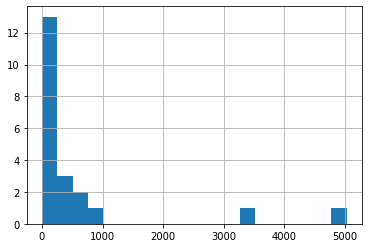

In [10]:
display(df_files_scoredbird_firstlast.head(2))
display(df_files_no_scoredbird_firstlast.head(2))
display(df_files_all_audio.head(2))
df_files_all_audio.file_num.hist(bins=20)

In [11]:
df_meta = pd.read_csv("../input/birdclef-2022/train_metadata.csv")
df_meta = df_meta[["primary_label","secondary_labels","rating","filename"]]
df_meta["filename"] = df_meta.filename.apply(lambda x: x[x.find("/")+1:])

print(df_meta.shape)
df_meta.head(2)

(14852, 4)


,primary_label,secondary_labels,rating,filename
0,afrsil1,[],2.5,XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",3.5,XC175522.ogg


(901, 626, 3)


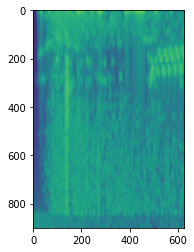

In [12]:
b = 0
n = 0
p = df_files_scoredbird_firstlast.path[b] + os.listdir(df_files_scoredbird_firstlast.path[b])[n]
print(get_img(p).shape)
plt.imshow(get_img(p))

# Define model

In [13]:
# Save model files for inference
download_path = snapshot_download(repo_id="facebook/wav2vec2-base-960h")
shutil.move(download_path, "./wav2vec/")

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

'./wav2vec/'

Dataloader

In [14]:
class BirdCLEF_Dataset(Dataset):
    
    def __init__(self, df, transforms=None, output_label=True, is_train=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms   = transforms
        self.output_label = output_label
        self.is_train     = is_train
        self.processor    = Wav2Vec2Processor.from_pretrained("./wav2vec/")
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        img_path = self.df.loc[index].img_path
        img_num  = int(img_path[-7:-4])  # Extract XXX from XXX.jpg
        img      = get_img(img_path).copy()
        waveform, sr = torchaudio.load(self.df.loc[index].audio_path)
        waveform = waveform[0]
        if len(waveform) < sr*5:
            rep      = round(float(sr*5) / len(waveform))
            waveform = waveform.repeat(int(rep)+1)
            waveform = waveform[:sr*5]
        else:
            if self.is_train:
                if -1 < img_path.find("000.jpg"):
                    waveform = waveform[:sr*5]  # First 5 seconds
                else:
                    waveform = waveform[-sr*5:] # Last 5 seconds
            else:
                sta = sr*5*img_num
                end = sr*5*(img_num+1)
                if len(waveform[sta:end]) == sr*5:
                    waveform = waveform[sta:end]
                else:
                    waveform = waveform[-sr*5:]                
        waveform = self.processor(waveform, sampling_rate=16000, return_tensors="pt").input_values
        # This is an input value to identify secondaly labels
        primary_label    = torch.from_numpy(np.array(self.df.loc[index].label))
        # This is the Y values for BCE loss. The type should be float16 to match with model output
        secondaly_labels = np.array([np.eye(CFG["class_num"], dtype=np.float16)[l] for l in self.df.loc[index, "labels"]]).sum(0)
        secondaly_labels = torch.from_numpy(secondaly_labels)
        if self.transforms:
            if self.is_train:
                p = np.random.rand(1)
                if p < 0.5:
                    # Horizontal flip
                    img      = img[:, ::-1]
                    waveform = waveform.flip(0)
            img = self.transforms(image=img)['image']
        if self.output_label:
            return img, waveform.reshape(-1), primary_label, secondaly_labels
        return img, waveform.reshape(-1), primary_label
    
def get_train_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        OneOf([
            Cutout(max_h_size=5, max_w_size=16),
            CoarseDropout(max_holes=4),
            ], p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

def get_valid_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

def prepare_dataloader(df, custom=True):
    df = df.copy()
    if custom:
        train      = df[df.is_valid==0].reset_index(drop=True).copy()
        valid      = df[df.is_valid==1].reset_index(drop=True).copy()
        train_ds   = BirdCLEF_Dataset(train, transforms=get_train_transforms())
        valid_ds   = BirdCLEF_Dataset(valid, transforms=get_valid_transforms(), is_train=False)
        dataloader = DataLoaders.from_dsets(train_ds, valid_ds, bs=CFG['batch_size'])
        if -1 < CFG["device"].find("cuda"):
            dataloader = dataloader.cuda()
    else:
        dataloader = ImageDataLoaders.from_df(
            df,
            valid_col='is_valid',
            seed=CFG["seed"],
            fn_col='path',
            label_col="label",
            y_block=CategoryBlock,
            bs=CFG['batch_size'],
            n=CFG["n_data"],
            shuffle=True,
            num_workers=CFG['num_workers'],
            item_tfms=Resize(CFG['size']),
            batch_tfms=setup_aug_tfms([Flip(), RandomErasing(), AffineCoordTfm()])
        )
    return dataloader

Metrics and loss

In [15]:
def rmse(input, target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

def self_f1_score(input, target):
    input  = input.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    return f1_score(target, input>0.3, average="micro")

# https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/213075
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)
        loss = targets * self.alpha * \
            (1. - probas)**self.gamma * bce_loss + \
            (1. - targets) * probas**self.gamma * bce_loss
        loss = loss.mean()
        return loss

Models

In [16]:
class ImageAndAudioModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.img_model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        self.audio_model = Wav2Vec2ForCTC.from_pretrained("./wav2vec/") #.to(CFG["device"])
        num_features = self.img_model.num_features
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(499*32, 1024)
        self.linear2 = nn.Linear(num_features+1024, 127)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, w):
        x1 = self.img_model(x)
        x2 = self.audio_model(w).logits
        x2 = self.flatten(x2)
        x2 = self.linear1(x2)
        x  = torch.cat((x1, x2), 1)
        x  = self.dropout(x)
        out = self.linear2(x)
        return out

class ImageAndAudioModelForScoredBird(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_model = ImageAndAudioModel(CFG["model"], pretrained=False)
        self.pre_model.load_state_dict(torch.load(CFG['pretrain']))
        self.linear    = nn.Linear(127+1, CFG["class_num"])

    def forward(self, x, w, p):
        x = self.pre_model(x, w)
        p = p.view(-1, 1)
        x = torch.cat((x, p), 1)
        out = self.linear(x)
        return out
    
def get_learner(df):
    dataloader = prepare_dataloader(df)
    model   = ImageAndAudioModelForScoredBird()
    learner = Learner(
        dataloader,
        model,
        loss_func=BCEFocalLoss(),
        metrics=AccumMetric(self_f1_score)).to_fp16()
    return learner

# Train model

In [17]:
for i in range(CFG["fold"]):
    df_train        = make_train_df(df_files_scoredbird_firstlast, i, 1)
    df_train_others = make_train_df_other_birds(df_files_no_scoredbird_firstlast, i)
    df_valid = make_train_df(df_files_all_audio,  i, 0, exclusion_files)
    df_train = pd.concat([df_train, df_train_others, df_valid]).reset_index(drop=True)
    print(df_train[df_train.is_valid==0].shape, df_train[df_train.is_valid==1].shape)

    learn = get_learner(df_train)
    learn.fit_one_cycle(
        CFG["epochs"],
        CFG["lr"],
        cbs=[SaveModelCallback(monitor='self_f1_score',
                               comp=np.greater),
             EarlyStoppingCallback(monitor='self_f1_score',
                                   comp=np.greater,
                                   patience=CFG['early_stopping'])]
    )
    shutil.move("./models/model.pth", f"./models/{CFG['save_name']}_fold{i}.pth")
    
    del learn
    torch.cuda.empty_cache()
    gc.collect()

(4400, 10) (2946, 10)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at ./wav2vec/ and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,train_loss,valid_loss,self_f1_score,time
0,0.006160,0.015030,0.956035,23:34
1,0.002547,0.014173,0.959783,22:54


Better model found at epoch 0 with self_f1_score value: 0.9560347117683521.
Better model found at epoch 1 with self_f1_score value: 0.9597833466158977.
